## Fraction of halo-like stars in Gaia RVS sample as a function of FeH_template



## Import modules

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function

import os, os.path 
#os.environ["OMP_NUM_THREADS"] = "1"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import math
import numpy
import numpy as np
import scipy
from scipy import stats
import datetime, time


#agama
import agama, numpy
import configparser
from scipy.optimize import minimize
from useful_functions import *
agama.setUnits( mass=1., length=1, velocity=1)
_k = 4.74047

#import emcee, corner
#import multiprocessing as mp

#PyGaia
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry.vectorastrometry import cartesianToSpherical, astrometryToPhaseSpace, phaseSpaceToAstrometry
from pygaia.errors.astrometric import properMotionErrorSkyAvg, properMotionMinError, properMotionMaxError
from pygaia.photometry.utils import vminiFromSpt, vabsFromSpt
from pygaia.photometry.transformations import gminvFromVmini

#read table
from astropy import table
from astropy.table import Table
import pandas
import copy 

#plot
import matplotlib
from matplotlib import pyplot
from matplotlib.ticker import MaxNLocator

pyplot.rcParams['ps.useafm'] = True
pyplot.rcParams['pdf.use14corefonts'] = True
pyplot.rcParams['text.usetex'] = True
#
#pyplot.rcParams["font.family"] = ["Computer Modern"]

In [2]:
_xGC_sun_kpc = -8.178  #you can set to (-_R0) if you want
_yGC_sun_kpc =  0.
_zGC_sun_kpc =  0.
_vxGC_sun    =  11.1
_vyGC_sun    =  247.30 #245.61  #232.24 #you can set to (_V0) if you want
_vzGC_sun    =  7.25

#LSR 233.37 

In [3]:
# set potential
potM17 = agama.Potential('/Users/kohei/my_libs_3/Agama/data/McMillan17.ini')

## Read data 

In [30]:
# read
inputfile_m1p5 = '../RVS_0absb_withplx_FeHm1p5_Teff-result.fits'
data_m1p5 =table.Table.read(inputfile_m1p5)

inputfile_m1p0 = '../RVS_0absb_withplx_FeHm1p0_Teff-result.fits'
data_m1p0 =table.Table.read(inputfile_m1p0)

inputfile_m0p5 = '../RVS_0absb_withplx_FeHm0p5_Teff-result.fits'
data_m0p5 =table.Table.read(inputfile_m0p5)

inputfile_m0p0 = '../RVS_0absb_withplx_FeHm0p0_Teff-result.fits'
data_m0p0 =table.Table.read(inputfile_m0p0)


inputfile_ruwe_m1p5 = '../RVS_0absb_withplx_FeHm1p5_Teff_ruwe1p4-result.fits'
data_ruwe_m1p5 =table.Table.read(inputfile_ruwe_m1p5)

inputfile_ruwe_m1p0 = '../RVS_0absb_withplx_FeHm1p0_Teff_ruwe1p4-result.fits'
data_ruwe_m1p0 =table.Table.read(inputfile_ruwe_m1p0)

inputfile_ruwe_m0p5 = '../RVS_0absb_withplx_FeHm0p5_Teff_ruwe1p4-result.fits'
data_ruwe_m0p5 =table.Table.read(inputfile_ruwe_m0p5)

inputfile_ruwe_m0p0 = '../RVS_0absb_withplx_FeHm0p0_Teff_ruwe1p4-result.fits'
data_ruwe_m0p0 =table.Table.read(inputfile_ruwe_m0p0)

In [31]:
data_ruwe_m1p5.columns

<TableColumns names=('source_id','ra','dec','b','l','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','pmra_pmdec_corr','radial_velocity','radial_velocity_error','rv_template_fe_h','teff_val','bp_rp','phot_g_mean_mag','ruwe')>

In [32]:
data_ruwe_m1p5

source_id,ra,dec,b,l,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,pmra_pmdec_corr,radial_velocity,radial_velocity_error,rv_template_fe_h,teff_val,bp_rp,phot_g_mean_mag,ruwe
,deg,deg,deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,km / s,km / s,dex,K,mag,mag,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32
2021659939697145728,295.2736692126975,25.330212432523595,1.2693896533258162,60.93275623833162,2.1587254165453444,0.021978824691060835,-13.992715222049894,0.03179828287693372,-12.799978783796927,0.035195900160036264,0.15626489,10.085115397627476,5.955380543867405,-1.5,5316.6665,1.0075178,13.362812,0.9555377
6680793183361589248,307.1768672145168,-39.93369279524846,-35.00973381829829,1.4852858891748753,2.4261515456258382,0.05161408628356239,-0.6991025279894931,0.07367573236906141,-5.530492089850285,0.048105199285201496,0.12262978,98.26251032031934,2.152257917103852,-1.5,6586.75,0.75707245,12.328775,0.95855397
4464123419019116800,245.7915502233838,14.85015729251597,39.44949151792625,30.142959222634655,2.5419723037854274,0.032811183462363,-38.17754551476902,0.03883294345817168,24.877966406650508,0.03506092758655774,0.090929046,88.5375004897943,1.4171791935905744,-1.5,6276.0,0.72356606,12.254468,1.173548
6680582455086213888,306.80631051290396,-41.05526923541763,-34.88168811042783,0.08314122238979883,0.366813737273878,0.03882659406578826,1.9961721517089273,0.06894613581945361,-16.14139794192195,0.050602610832026475,0.331154,-34.4691218071931,0.6398117528864992,-1.5,4944.335,1.1711397,12.3899765,1.0513302
4464187117677409152,246.24024192233955,15.544803130344281,39.32023528188301,31.188735952399846,0.17841098402268907,0.03157378343550294,-7.2752684469557485,0.036308007715289754,-3.363914859604666,0.03181255327813338,0.2038475,-107.73306429778876,0.3697044693659602,-1.5,4033.28,1.8142948,10.709339,1.0497265
5408456087388313344,151.64359598293723,-46.616887513965864,7.37990740562577,275.77945691652053,1.2950994980799324,0.031039732956553247,-39.4006466335881,0.04974334160096105,18.471760547905443,0.04741002189363211,0.21065955,157.32612945183763,0.8866430287455204,-1.5,5363.3335,0.9539671,12.577658,0.9960015
2065075423303939840,312.8742675415772,40.136649409050094,-2.660692211780911,81.42579153638879,1.3114692759200917,0.02669410975444519,0.8539574550881706,0.039409583676642046,-1.4800801883905441,0.04802414996517951,-0.09494415,-40.92563794202923,17.86913268130899,-1.5,7615.0,0.4389553,12.101724,0.8938512
4464150150895511040,245.79842872374059,15.197183454737598,39.57893149716283,30.56041217450119,0.7931181934438345,0.02698425673446758,6.596277906253839,0.035624863621675426,-14.391142731106058,0.03223029111485082,0.09151855,3.608551885815775,0.8293875867332007,-1.5,4922.0,1.1744156,12.871013,0.9158483


## Histogram of parallax-over-error

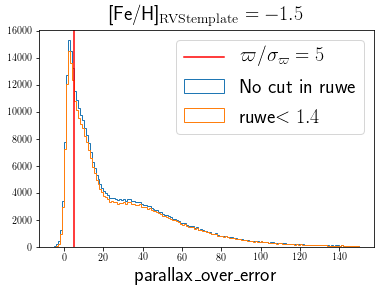

In [37]:

pyplot.hist(data_m1p5['parallax']/data_m1p5['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='No cut in ruwe')

pyplot.hist(data_ruwe_m1p5['parallax']/data_ruwe_m1p5['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='ruwe$<1.4$')


pyplot.axvline(x=5, c='red', label=r'$\varpi/\sigma_\varpi = 5$')


pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.5$', fontsize=20)
pyplot.show()


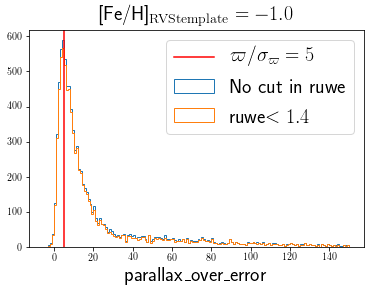

In [38]:

pyplot.hist(data_m1p0['parallax']/data_m1p0['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='No cut in ruwe')

pyplot.hist(data_ruwe_m1p0['parallax']/data_ruwe_m1p0['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='ruwe$<1.4$')


pyplot.axvline(x=5, c='red', label=r'$\varpi/\sigma_\varpi = 5$')



pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.0$', fontsize=20)
pyplot.show()



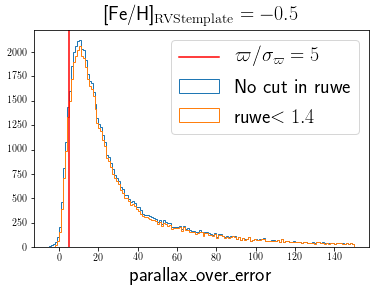

In [39]:

pyplot.hist(data_m0p5['parallax']/data_m0p5['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='No cut in ruwe')

pyplot.hist(data_ruwe_m0p5['parallax']/data_ruwe_m0p5['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='ruwe$<1.4$')


pyplot.axvline(x=5, c='red', label=r'$\varpi/\sigma_\varpi = 5$')


pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-0.5$', fontsize=20)
pyplot.show()




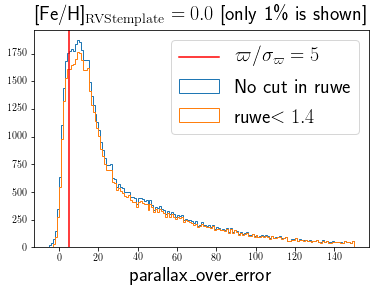

In [40]:

pyplot.hist(data_m0p0['parallax']/data_m0p0['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='No cut in ruwe')

pyplot.hist(data_ruwe_m0p0['parallax']/data_ruwe_m0p0['parallax_error'], 
            bins=numpy.linspace(-5,150,156), histtype='step', label='ruwe$<1.4$')


pyplot.axvline(x=5, c='red', label=r'$\varpi/\sigma_\varpi = 5$')



pyplot.legend(fontsize=20)

pyplot.xlabel(r'parallax\_over\_error', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$ [only 1\% is shown]', fontsize=20)
pyplot.show()





## Toomre ediagram

In [11]:
def analyze_data(data):
    source_id             = numpy.array(data['source_id']            [:])
    l                     = numpy.array(data['l']                    [:])
    b                     = numpy.array(data['b']                    [:])
    ra                    = numpy.array(data['ra']                   [:])
    dec                   = numpy.array(data['dec']                  [:])
    parallax              = numpy.array(data['parallax']             [:])
    parallax_error        = numpy.array(data['parallax_error']       [:])
    radial_velocity       = numpy.array(data['radial_velocity']      [:])
    radial_velocity_error = numpy.array(data['radial_velocity_error'][:])
    pmra                  = numpy.array(data['pmra']                 [:])
    pmdec                 = numpy.array(data['pmdec']                [:])
    #pmra_pmdec_corr       = numpy.array(data['pmra_pmdec_corr']      [:])
    
    parallax_over_error = parallax/parallax_error
    
    ell_radian, bee_radian, pml, pmb \
    = ICRS_to_GAL(deg2radian(ra),  
                  deg2radian(dec), 
                  pmra,
                  pmdec)


    xHelio_kpc, yHelio_kpc, zHelio_kpc, vxHelio, vyHelio, vzHelio \
    = astrometric_2_cartesian(parallax_mas_2_DM(parallax),
                              ell_radian,
                              bee_radian,
                              radial_velocity, 
                              pml, 
                              pmb)

    xGC_kpc = xHelio_kpc + _xGC_sun_kpc
    yGC_kpc = yHelio_kpc + _yGC_sun_kpc
    zGC_kpc = zHelio_kpc + _zGC_sun_kpc

    vxGC = vxHelio + _vxGC_sun
    vyGC = vyHelio + _vyGC_sun
    vzGC = vzHelio + _vzGC_sun


    R2GC_kpc = numpy.sqrt(xGC_kpc**2 + yGC_kpc**2)
    rGC_kpc  = numpy.sqrt(xGC_kpc**2 + yGC_kpc**2 + zGC_kpc**2)

    vR   = (xGC_kpc*vxGC + yGC_kpc*vyGC)/R2GC_kpc
    vPHI = (xGC_kpc*vyGC - yGC_kpc*vxGC)/R2GC_kpc

    vr     = (xGC_kpc*vxGC + yGC_kpc*vyGC + zGC_kpc*vzGC)/rGC_kpc
    vTHETA = (-zGC_kpc*xGC_kpc)/(rGC_kpc*R2GC_kpc)*vxGC + (-zGC_kpc*yGC_kpc)/(rGC_kpc*R2GC_kpc)*vyGC + (R2GC_kpc/rGC_kpc)*vzGC

    return vR, vPHI, vzGC, parallax_over_error



In [12]:
vR_m1p5, vPHI_m1p5, vzGC_m1p5, plxOvErr_m1p5 = analyze_data(data_m1p5)

/Users/kohei/rprocess/NearbyGaiaData/halo_fraction/useful_functions.py:618: RuntimeWarning: invalid value encountered in log10
  DM = 5.*( numpy.log10(1./parallax_mas) + 2. )
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/PyGaia-1.32-py3.6.egg/pygaia/astrometry/vectorastrometry.py:228: RuntimeWarning: invalid value encountered in less_equal


In [13]:
vR_m1p0, vPHI_m1p0, vzGC_m1p0, plxOvErr_m1p0 = analyze_data(data_m1p0)

In [14]:
vR_m0p5, vPHI_m0p5, vzGC_m0p5, plxOvErr_m0p5 = analyze_data(data_m0p5)

In [15]:
vR_m0p0, vPHI_m0p0, vzGC_m0p0, plxOvErr_m0p0 = analyze_data(data_m0p0)

In [41]:
vR_ruwe_m1p5, vPHI_ruwe_m1p5, vzGC_ruwe_m1p5, plxOvErr_ruwe_m1p5 = analyze_data(data_ruwe_m1p5)

/Users/kohei/rprocess/NearbyGaiaData/halo_fraction/useful_functions.py:618: RuntimeWarning: invalid value encountered in log10
  DM = 5.*( numpy.log10(1./parallax_mas) + 2. )
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/PyGaia-1.32-py3.6.egg/pygaia/astrometry/vectorastrometry.py:228: RuntimeWarning: invalid value encountered in less_equal


In [42]:
vR_ruwe_m1p0, vPHI_ruwe_m1p0, vzGC_ruwe_m1p0, plxOvErr_ruwe_m1p0 = analyze_data(data_ruwe_m1p0)

In [43]:
vR_ruwe_m0p5, vPHI_ruwe_m0p5, vzGC_ruwe_m0p5, plxOvErr_ruwe_m0p5 = analyze_data(data_ruwe_m0p5)

In [44]:
vR_ruwe_m0p0, vPHI_ruwe_m0p0, vzGC_ruwe_m0p0, plxOvErr_ruwe_m0p0 = analyze_data(data_ruwe_m0p0)

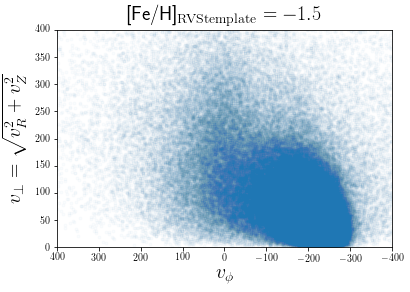

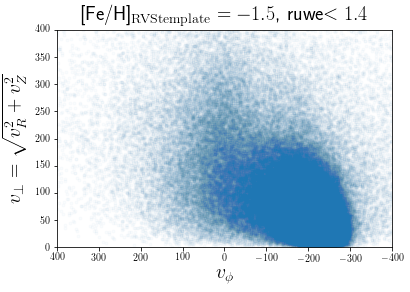

In [45]:
pyplot.plot(vPHI_m1p5, numpy.sqrt(vR_m1p5**2 + vzGC_m1p5**2), 
            '.', linestyle='None', alpha=0.02)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.5$', fontsize=20)
pyplot.show()

# ---

pyplot.plot(vPHI_ruwe_m1p5, numpy.sqrt(vR_ruwe_m1p5**2 + vzGC_ruwe_m1p5**2), 
            '.', linestyle='None', alpha=0.02)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.5$, ruwe$<1.4$', fontsize=20)
pyplot.show()




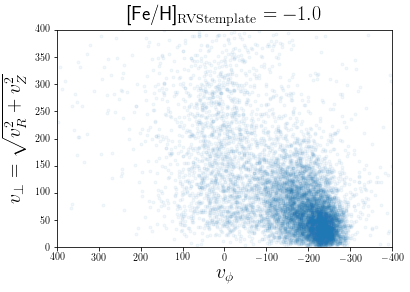

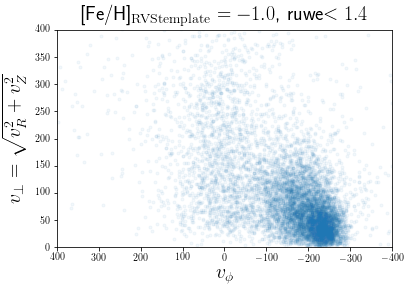

In [46]:
pyplot.plot(vPHI_m1p0, numpy.sqrt(vR_m1p0**2 + vzGC_m1p0**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.0$', fontsize=20)

pyplot.show()

# --

pyplot.plot(vPHI_ruwe_m1p0, numpy.sqrt(vR_ruwe_m1p0**2 + vzGC_ruwe_m1p0**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-1.0$, ruwe$<1.4$', fontsize=20)

pyplot.show()

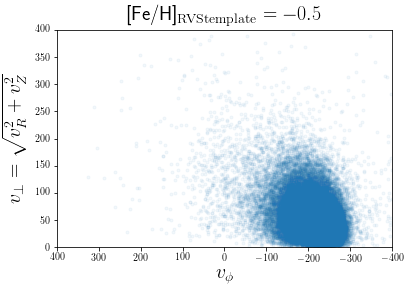

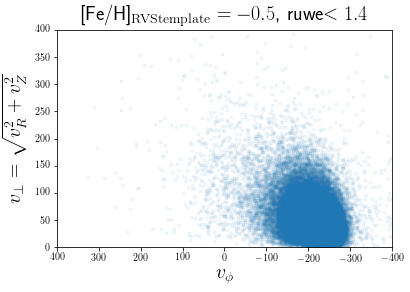

In [47]:
pyplot.plot(vPHI_m0p5, numpy.sqrt(vR_m0p5**2 + vzGC_m0p5**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-0.5$', fontsize=20)

pyplot.show()

# --

pyplot.plot(vPHI_ruwe_m0p5, numpy.sqrt(vR_ruwe_m0p5**2 + vzGC_ruwe_m0p5**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=-0.5$, ruwe$<1.4$', fontsize=20)

pyplot.show()

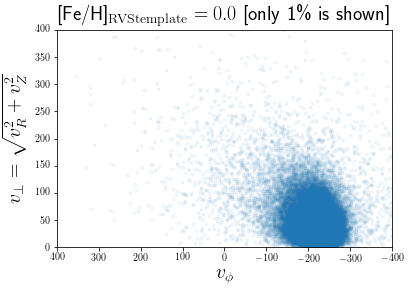

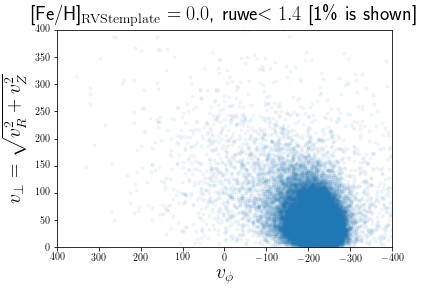

In [48]:
pyplot.plot(vPHI_m0p0, numpy.sqrt(vR_m0p0**2 + vzGC_m0p0**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$ [only 1\% is shown]', fontsize=20)


pyplot.show()

# --
pyplot.plot(vPHI_ruwe_m0p0, numpy.sqrt(vR_ruwe_m0p0**2 + vzGC_ruwe_m0p0**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$, ruwe$<1.4$ [1\% is shown]', fontsize=20)


pyplot.show()

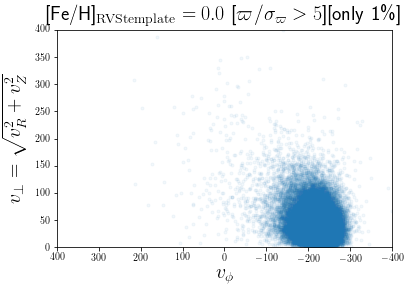

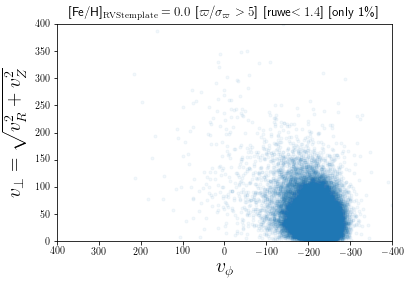

In [50]:
pyplot.plot(vPHI_m0p0[plxOvErr_m0p0>5], 
            numpy.sqrt(vR_m0p0[plxOvErr_m0p0>5]**2 + vzGC_m0p0[plxOvErr_m0p0>5]**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$ [$\varpi/\sigma_\varpi>5$][only 1\%]', fontsize=20)


pyplot.show()

#--
pyplot.plot(vPHI_ruwe_m0p0[plxOvErr_ruwe_m0p0>5], 
            numpy.sqrt(vR_ruwe_m0p0[plxOvErr_ruwe_m0p0>5]**2 + vzGC_ruwe_m0p0[plxOvErr_ruwe_m0p0>5]**2), 
            '.', linestyle='None', alpha=0.05)
pyplot.xlim([400,-400])
pyplot.ylim([0,400])

pyplot.xlabel(r'$v_\phi$', fontsize=20)
pyplot.ylabel(r'$v_\perp = \sqrt{v_R^2 + v_Z^2}$', fontsize=20)
pyplot.title(r'[Fe/H]$_\mathrm{RVStemplate}=0.0$ [$\varpi/\sigma_\varpi>5$] [ruwe$<1.4$] [only 1\%]', fontsize=13)

pyplot.show()

## The fraction of retrograde stars

In [70]:
N_m1p5          = len(vPHI_m1p5)
Nretro_m1p5     = len(vPHI_m1p5[vPHI_m1p5>0])
frac_retro_m1p5 = float(Nretro_m1p5)/N_m1p5

N_m1p0          = len(vPHI_m1p0)
Nretro_m1p0     = len(vPHI_m1p0[vPHI_m1p0>0])
frac_retro_m1p0 = float(Nretro_m1p0)/N_m1p0

N_m0p5          = len(vPHI_m0p5)
Nretro_m0p5     = len(vPHI_m0p5[vPHI_m0p5>0])
frac_retro_m0p5 = float(Nretro_m0p5)/N_m0p5

N_m0p0          = len(vPHI_m0p0)
Nretro_m0p0     = len(vPHI_m0p0[vPHI_m0p0>0])
frac_retro_m0p0 = float(Nretro_m0p0)/N_m0p0


#---
N_m1p5_good          = len(vPHI_m1p5[(plxOvErr_m1p5>5)])
Nretro_m1p5_good     = len(vPHI_m1p5[(plxOvErr_m1p5>5)*(vPHI_m1p5>0)])
frac_retro_m1p5_good = float(Nretro_m1p5_good)/N_m1p5_good

N_m1p0_good          = len(vPHI_m1p0[(plxOvErr_m1p0>5)])
Nretro_m1p0_good     = len(vPHI_m1p0[(plxOvErr_m1p0>5)*(vPHI_m1p0>0)])
frac_retro_m1p0_good = float(Nretro_m1p0_good)/N_m1p0_good

N_m0p5_good          = len(vPHI_m0p5[(plxOvErr_m0p5>5)])
Nretro_m0p5_good     = len(vPHI_m0p5[(plxOvErr_m0p5>5)*(vPHI_m0p5>0)])
frac_retro_m0p5_good = float(Nretro_m0p5_good)/N_m0p5_good

N_m0p0_good          = len(vPHI_m0p0[(plxOvErr_m0p0>5)])
Nretro_m0p0_good     = len(vPHI_m0p0[(plxOvErr_m0p0>5)*(vPHI_m0p0>0)])
frac_retro_m0p0_good = float(Nretro_m0p0_good)/N_m0p0_good

#---
N_ruwe_m1p5          = len(vPHI_ruwe_m1p5)
Nretro_ruwe_m1p5     = len(vPHI_ruwe_m1p5[vPHI_ruwe_m1p5>0])
frac_retro_ruwe_m1p5 = float(Nretro_ruwe_m1p5)/N_ruwe_m1p5

N_ruwe_m1p0          = len(vPHI_ruwe_m1p0)
Nretro_ruwe_m1p0     = len(vPHI_ruwe_m1p0[vPHI_ruwe_m1p0>0])
frac_retro_ruwe_m1p0 = float(Nretro_ruwe_m1p0)/N_ruwe_m1p0

N_ruwe_m0p5          = len(vPHI_ruwe_m0p5)
Nretro_ruwe_m0p5     = len(vPHI_ruwe_m0p5[vPHI_ruwe_m0p5>0])
frac_retro_ruwe_m0p5 = float(Nretro_ruwe_m0p5)/N_ruwe_m0p5

N_ruwe_m0p0          = len(vPHI_ruwe_m0p0)
Nretro_ruwe_m0p0     = len(vPHI_ruwe_m0p0[vPHI_ruwe_m0p0>0])
frac_retro_ruwe_m0p0 = float(Nretro_ruwe_m0p0)/N_ruwe_m0p0


#---
N_ruwe_m1p5_good          = len(vPHI_ruwe_m1p5[(plxOvErr_ruwe_m1p5>5)])
Nretro_ruwe_m1p5_good     = len(vPHI_ruwe_m1p5[(plxOvErr_ruwe_m1p5>5)*(vPHI_ruwe_m1p5>0)])
frac_retro_ruwe_m1p5_good = float(Nretro_ruwe_m1p5_good)/N_ruwe_m1p5_good

N_ruwe_m1p0_good          = len(vPHI_ruwe_m1p0[(plxOvErr_ruwe_m1p0>5)])
Nretro_ruwe_m1p0_good     = len(vPHI_ruwe_m1p0[(plxOvErr_ruwe_m1p0>5)*(vPHI_ruwe_m1p0>0)])
frac_retro_ruwe_m1p0_good = float(Nretro_ruwe_m1p0_good)/N_ruwe_m1p0_good

N_ruwe_m0p5_good          = len(vPHI_ruwe_m0p5[(plxOvErr_ruwe_m0p5>5)])
Nretro_ruwe_m0p5_good     = len(vPHI_ruwe_m0p5[(plxOvErr_ruwe_m0p5>5)*(vPHI_ruwe_m0p5>0)])
frac_retro_ruwe_m0p5_good = float(Nretro_ruwe_m0p5_good)/N_ruwe_m0p5_good

N_ruwe_m0p0_good          = len(vPHI_ruwe_m0p0[(plxOvErr_ruwe_m0p0>5)])
Nretro_ruwe_m0p0_good     = len(vPHI_ruwe_m0p0[(plxOvErr_ruwe_m0p0>5)*(vPHI_ruwe_m0p0>0)])
frac_retro_ruwe_m0p0_good = float(Nretro_ruwe_m0p0_good)/N_ruwe_m0p0_good

#---



array_FeH = numpy.array([-1.5, -1., -0.5, 0])

array_frac_retro= numpy.array([frac_retro_m1p5, 
                               frac_retro_m1p0, 
                               frac_retro_m0p5,
                               frac_retro_m0p0 ])

array_frac_retro_ruwe= numpy.array([frac_retro_ruwe_m1p5, 
                               frac_retro_ruwe_m1p0, 
                               frac_retro_ruwe_m0p5,
                               frac_retro_ruwe_m0p0 ])

array_frac_retro_good= numpy.array([frac_retro_m1p5_good, 
                                    frac_retro_m1p0_good, 
                                    frac_retro_m0p5_good,
                                    frac_retro_m0p0_good ])

array_frac_retro_ruwe_good= numpy.array([frac_retro_ruwe_m1p5_good, 
                                    frac_retro_ruwe_m1p0_good, 
                                    frac_retro_ruwe_m0p5_good,
                                    frac_retro_ruwe_m0p0_good ])


array_N_retro   = numpy.array([Nretro_m1p5, 
                               Nretro_m1p0, 
                               Nretro_m0p5,
                               Nretro_m0p0*1e2 ])

array_N_retro_ruwe= numpy.array([Nretro_ruwe_m1p5, 
                               Nretro_ruwe_m1p0, 
                               Nretro_ruwe_m0p5,
                               Nretro_ruwe_m0p0*1e2 ])

array_N_retro_good=numpy.array([Nretro_m1p5_good, 
                                Nretro_m1p0_good, 
                                Nretro_m0p5_good,
                                Nretro_m0p0_good*1e2 ])

array_N_retro_ruwe_good=numpy.array([Nretro_ruwe_m1p5_good, 
                                Nretro_ruwe_m1p0_good, 
                                Nretro_ruwe_m0p5_good,
                                Nretro_ruwe_m0p0_good*1e2 ])


print('# [Fe/H], N(total), N(retrograde), N(retrograde)/N(total)')
print('#','-'*60)
print('# No cut in ruwe or parallax_over_error')
print('#','-'*60)

print(-1.5, Nretro_m1p5,     N_m1p5,     '%.4lf' % (frac_retro_m1p5))
print(-1.0, Nretro_m1p0,     N_m1p0,     '%.4lf' % (frac_retro_m1p0))
print(-0.5, Nretro_m0p5,     N_m0p5,     '%.4lf' % (frac_retro_m0p5))
print( 0.0, Nretro_m0p0*100, N_m0p0*100, '%.4lf' % (frac_retro_m0p0), '# Estimated from 1 percent subsample')

print('#','-'*60)
print('# No cut in ruwe; parallax_over_error>5')
print('#','-'*60)

print(-1.5, Nretro_m1p5_good,     N_m1p5_good,     '%.4lf' % (frac_retro_m1p5_good))
print(-1.0, Nretro_m1p0_good,     N_m1p0_good,     '%.4lf' % (frac_retro_m1p0_good))
print(-0.5, Nretro_m0p5_good,     N_m0p5_good,     '%.4lf' % (frac_retro_m0p5_good))
print( 0.0, Nretro_m0p0_good*100, N_m0p0_good*100, '%.4lf' % (frac_retro_m0p0_good), '# Estimated from 1 percent subsample')


print('#','-'*60)
print('# ruwe<1.4; No cut in parallax_over_error')
print('#','-'*60)

print(-1.5, Nretro_ruwe_m1p5,     N_ruwe_m1p5,     '%.4lf' % (frac_retro_ruwe_m1p5 ))
print(-1.0, Nretro_ruwe_m1p0,     N_ruwe_m1p0,     '%.4lf' % (frac_retro_ruwe_m1p0 ))
print(-0.5, Nretro_ruwe_m0p5,     N_ruwe_m0p5,     '%.4lf' % (frac_retro_ruwe_m0p5 ))
print( 0.0, Nretro_ruwe_m0p0*100, N_ruwe_m0p0*100, '%.4lf' % (frac_retro_ruwe_m0p0 ), '# Estimated from 1 percent subsample')

print('#','-'*60)
print('# ruwe<1.4, parallax_over_error>5')
print('#','-'*60)

print(-1.5, Nretro_ruwe_m1p5_good,     N_ruwe_m1p5_good,     '%.4lf' % (frac_retro_ruwe_m1p5_good))
print(-1.0, Nretro_ruwe_m1p0_good,     N_ruwe_m1p0_good,     '%.4lf' % (frac_retro_ruwe_m1p0_good))
print(-0.5, Nretro_ruwe_m0p5_good,     N_ruwe_m0p5_good,     '%.4lf' % (frac_retro_ruwe_m0p5_good))
print( 0.0, Nretro_ruwe_m0p0_good*100, N_ruwe_m0p0_good*100, '%.4lf' % (frac_retro_ruwe_m0p0_good), '# Estimated from 1 percent subsample')



# [Fe/H], N(total), N(retrograde), N(retrograde)/N(total)
# ------------------------------------------------------------
# No cut in ruwe or parallax_over_error
# ------------------------------------------------------------
-1.5 24633 366241 0.0673
-1.0 1144 9364 0.1222
-0.5 405 63408 0.0064
0.0 40800 6536800 0.0062 # Estimated from 1 percent subsample
# ------------------------------------------------------------
# No cut in ruwe; parallax_over_error>5
# ------------------------------------------------------------
-1.5 10667 296783 0.0359
-1.0 605 7230 0.0837
-0.5 210 59180 0.0035
0.0 9500 5806400 0.0016 # Estimated from 1 percent subsample
# ------------------------------------------------------------
# ruwe<1.4; No cut in parallax_over_error
# ------------------------------------------------------------
-1.5 23816 342376 0.0696
-1.0 1131 8833 0.1280
-0.5 386 59931 0.0064
0.0 39200 6097100 0.0064 # Estimated from 1 percent subsample
# -------------------------------------------------

/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Users/kohei/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/kohei/.pyenv/version

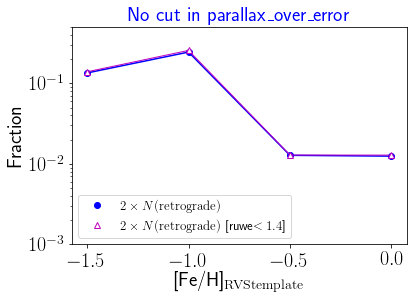

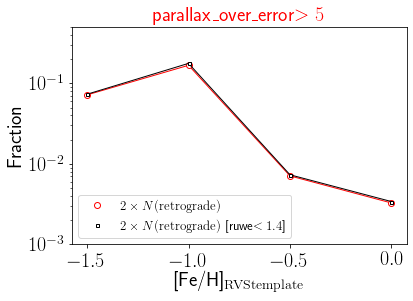

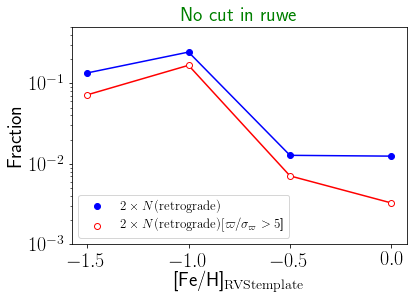

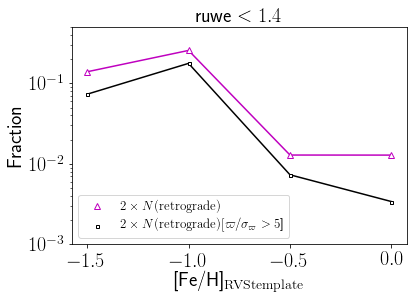

In [102]:

pyplot.plot(array_FeH, 
            array_frac_retro*2.,  
            'b-')
pyplot.plot(array_FeH, 
            array_frac_retro*2.,  
            'bo', 
            label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_frac_retro_ruwe*2.,  
            'm-', linewidth=1)
pyplot.plot(array_FeH, 
            array_frac_retro_ruwe*2.,  
            'w^', markeredgecolor='m',
            label=r'$2\times N(\mathrm{retrograde}) $ [ruwe$<1.4$]')


pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([0.001,0.5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Fraction', fontsize=20)

pyplot.legend(loc='lower left', fontsize=13)
pyplot.title(r'No cut in parallax\_over\_error', fontsize=20, color='b')


pyplot.show()


# ----- 

#pyplot.plot(array_FeH, 
#            array_N_retro_good,  
#            'r--', label=r'$N(\mathrm{retrograde})$')
#pyplot.plot(array_FeH, 
#            array_N_retro_good,
#            'ro')

pyplot.plot(array_FeH, 
            array_frac_retro_good*2.,  
            'r-', linewidth=1)
pyplot.plot(array_FeH, 
            array_frac_retro_good*2.,  
            'wo', markeredgecolor='r', 
            label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_frac_retro_ruwe_good*2.,  
            'k-', linewidth=1)
pyplot.plot(array_FeH, 
            array_frac_retro_ruwe_good*2.,  
            'ws', markeredgecolor='k', markersize=3,
            label=r'$2\times N(\mathrm{retrograde}) $ [ruwe$<1.4$]')



pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([0.001,0.5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Fraction', fontsize=20)

pyplot.legend(loc='lower left', fontsize=13)
pyplot.title(r'parallax\_over\_error$>5$', fontsize=20, color='r')

pyplot.show()


# ----- 

pyplot.plot(array_FeH, 
            array_frac_retro*2.,  
            'b-')
pyplot.plot(array_FeH, 
            array_frac_retro*2.,  
            'bo', label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_frac_retro_good*2.,  
            'r-')
pyplot.plot(array_FeH, 
            array_frac_retro_good*2.,  
            'wo', markeredgecolor='r', 
            label=r'$2\times N(\mathrm{retrograde}) [\varpi/\sigma_\varpi>5$]')


pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([0.001,0.5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Fraction', fontsize=20)

pyplot.legend(loc='lower left', fontsize=13)
pyplot.title(r'No cut in ruwe', fontsize=20, color='g')

pyplot.show()

#---

pyplot.plot(array_FeH, 
            array_frac_retro_ruwe*2.,  
            'm-')
pyplot.plot(array_FeH, 
            array_frac_retro_ruwe*2.,  
            'w^', markeredgecolor='m', 
            label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_frac_retro_ruwe_good*2.,  
            'k-')
pyplot.plot(array_FeH, 
            array_frac_retro_ruwe_good*2.,  
            'ws', markeredgecolor='k', markersize=3,
            label=r'$2\times N(\mathrm{retrograde}) [\varpi/\sigma_\varpi>5$]')


pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([0.001,0.5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Fraction', fontsize=20)

pyplot.legend(loc='lower left', fontsize=13)
pyplot.title(r'ruwe $<1.4$', fontsize=20, color='k')

pyplot.show()





## The number of retrograde stars

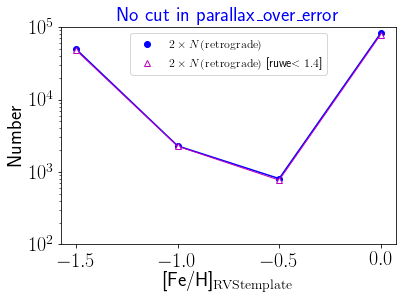

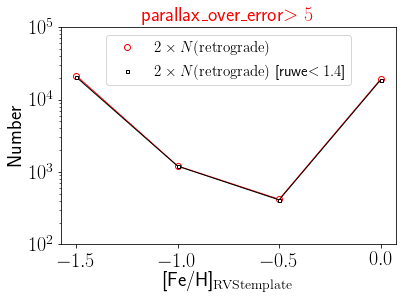

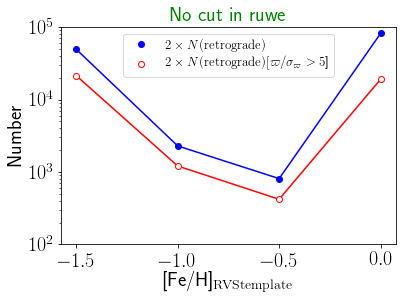

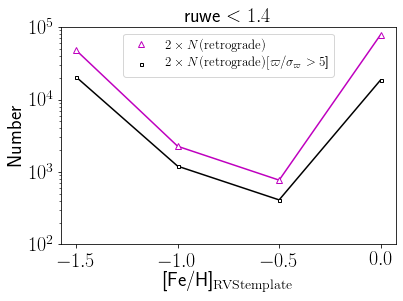

In [97]:
#pyplot.plot(array_FeH, 
#            array_N_retro,  
#            'b--', label=r'$N(\mathrm{retrograde})$')
#pyplot.plot(array_FeH, 
#            array_N_retro,
#            'bo')

pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'b-')
pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'bo', 
            label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_N_retro_ruwe*2.,  
            'm-', linewidth=1)
pyplot.plot(array_FeH, 
            array_N_retro_ruwe*2.,  
            'w^', markeredgecolor='m',
            label=r'$2\times N(\mathrm{retrograde}) $ [ruwe$<1.4$]')


pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([1e2,1e5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Number', fontsize=20)

pyplot.legend(loc='upper center', fontsize=12)
pyplot.title(r'No cut in parallax\_over\_error', fontsize=20, color='b')


pyplot.show()


# ----- 

#pyplot.plot(array_FeH, 
#            array_N_retro_good,  
#            'r--', label=r'$N(\mathrm{retrograde})$')
#pyplot.plot(array_FeH, 
#            array_N_retro_good,
#            'ro')

pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'r-', linewidth=1)
pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'wo', markeredgecolor='r', 
            label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_N_retro_ruwe_good*2.,  
            'k-', linewidth=1)
pyplot.plot(array_FeH, 
            array_N_retro_ruwe_good*2.,  
            'ws', markeredgecolor='k', markersize=3,
            label=r'$2\times N(\mathrm{retrograde}) $ [ruwe$<1.4$]')



pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([1e2,1e5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Number', fontsize=20)

pyplot.legend(loc='upper center', fontsize=15)
pyplot.title(r'parallax\_over\_error$>5$', fontsize=20, color='r')

pyplot.show()


# ----- 

pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'b-')
pyplot.plot(array_FeH, 
            array_N_retro*2.,  
            'bo', label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'r-')
pyplot.plot(array_FeH, 
            array_N_retro_good*2.,  
            'wo', markeredgecolor='r', 
            label=r'$2\times N(\mathrm{retrograde}) [\varpi/\sigma_\varpi>5$]')


pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([1e2,1e5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Number', fontsize=20)

pyplot.legend(loc='upper center', fontsize=13)
pyplot.title(r'No cut in ruwe', fontsize=20, color='g')

pyplot.show()

#---

pyplot.plot(array_FeH, 
            array_N_retro_ruwe*2.,  
            'm-')
pyplot.plot(array_FeH, 
            array_N_retro_ruwe*2.,  
            'w^', markeredgecolor='m', 
            label=r'$2\times N(\mathrm{retrograde})$')

pyplot.plot(array_FeH, 
            array_N_retro_ruwe_good*2.,  
            'k-')
pyplot.plot(array_FeH, 
            array_N_retro_ruwe_good*2.,  
            'ws', markeredgecolor='k', markersize=3,
            label=r'$2\times N(\mathrm{retrograde}) [\varpi/\sigma_\varpi>5$]')


pyplot.xticks(numpy.linspace(-1.5,0.,4),fontsize=20)
pyplot.yticks(numpy.linspace(0.0,0.25,6),fontsize=20)
pyplot.ylim([1e2,1e5])
pyplot.yscale('log')
pyplot.xlabel(r'[Fe/H]$_\mathrm{RVStemplate}$', fontsize=20)
pyplot.ylabel(r'Number', fontsize=20)

pyplot.legend(loc='upper center', fontsize=13)
pyplot.title(r'ruwe $<1.4$', fontsize=20, color='k')

pyplot.show()




### The most important factor that determines the number of retrograde stars is parallax_over_error. 
### With the strict cut of parallax_over_error>5, we have 40,000 halo-like stars. 
### If we relax this cut, the number of halo-like stars gets 130,000. 